In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
os.environ["LAL_DATA_PATH"] = "../data"

In [3]:
import bilby.gw
import gwpy
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate

/Users/keefemitman/Desktop/Research/MemoryPop/.venv/lib/python3.11/site-packages/gwpy/time/_ligotimegps.py:42: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [4]:
import sys
sys.path.insert(0, '..')

from gw_residuals import compute_one_sample_fd, compute_bbh_residuals_with_spline_calibration

In [5]:
res = compute_bbh_residuals_with_spline_calibration(
    "../data/posterior_samples_NRSur7dq4.h5",
    event="GW250114_082203",
    max_samples=1000,
    thin=1
)

# Complex FD residuals: shape (nsamp, nfreq)
H1_res_fd = res["fd"]["H1"]["residual"]

res["config"]

2026-02-14  12:22:59 PESummary WARNING : Unable to install 'pycbc'. You will not be able to use some of the inbuilt functions.
2026-02-14  12:22:59 PESummary WARNING : Unable to install 'pycbc'. You will not be able to use some of the inbuilt functions.
INFO:gw_residuals:Fetching GWOSC open strain: H1 [1420878139.2, 1420878143.2), dataset=O4b3Disc
INFO:gwpy.timeseries.timeseries:Found 1 possible sources
INFO:gwpy.timeseries.timeseries:Attemping access with 'gwosc' [1/1]
INFO:gw_residuals:Fetching GWOSC open strain: L1 [1420878139.2, 1420878143.2), dataset=O4b3Disc
INFO:gwpy.timeseries.timeseries:Found 1 possible sources
INFO:gwpy.timeseries.timeseries:Attemping access with 'gwosc' [1/1]
12:23 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=4.0, sampling_frequency=4096.0, start_time=0, frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, time_domain_source_model=None, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_pa

AnalysisConfig(label='bilby-NRSur7dq4_prod-reweighted', event='GW250114_082203', detectors=('H1', 'L1'), trigger_time=1420878141.2, start_time=1420878139.2, end_time=1420878143.2, duration=4.0, sampling_frequency=4096.0, minimum_frequency={'H1': 20.0, 'L1': 20.0}, maximum_frequency=None, reference_frequency=50.0, waveform_approximant='NRSur7dq4', config_dict={'config': {'accounting': 'ligo.prod.o4.cbc.pe.bilby', 'accounting-user': 'teagan.clarke', 'additional-transfer-paths': '[/scratch/lalsimulation/NRSur7dq4_v1.0.h5]', 'allow-tape': 'True', 'analysis-executable': '/home/jacob.lange/.conda/envs/20250724-bilby-snr-fixed-container-yml/bin/bilby_pipe_analysis', 'analysis-executable-parser': 'None', 'calibration-correction-type': 'None', 'calibration-lookup-table': 'None', 'calibration-marginalization': 'False', 'calibration-model': 'CubicSpline', 'calibration-prior-boundary': 'reflective', 'catch-waveform-errors': 'True', 'channel-dict': '{ H1:GDS-CALIB_STRAIN_CLEAN_AR,L1:GDS-CALIB_STRAI

# Using the primary interface

You can use `compute_one_sample_fd()` directly for more control:

In [6]:
# Example: compute for a single sample using the primary interface
ifos = res['ifos']
wfgen = res['waveform_generator']
sample = res['samples'][0]

# This is now the primary public interface
result = compute_one_sample_fd(ifos, wfgen, sample)

# Access model and residual for each detector
for det_name, data in result.items():
    print(f"{det_name}: model shape = {data['model_fd'].shape}, residual shape = {data['residual_fd'].shape}")

H1: model shape = (8193,), residual shape = (8193,)
L1: model shape = (8193,), residual shape = (8193,)


## Plot the residual and model

Text(0.5, 0, 'Frequency bin')

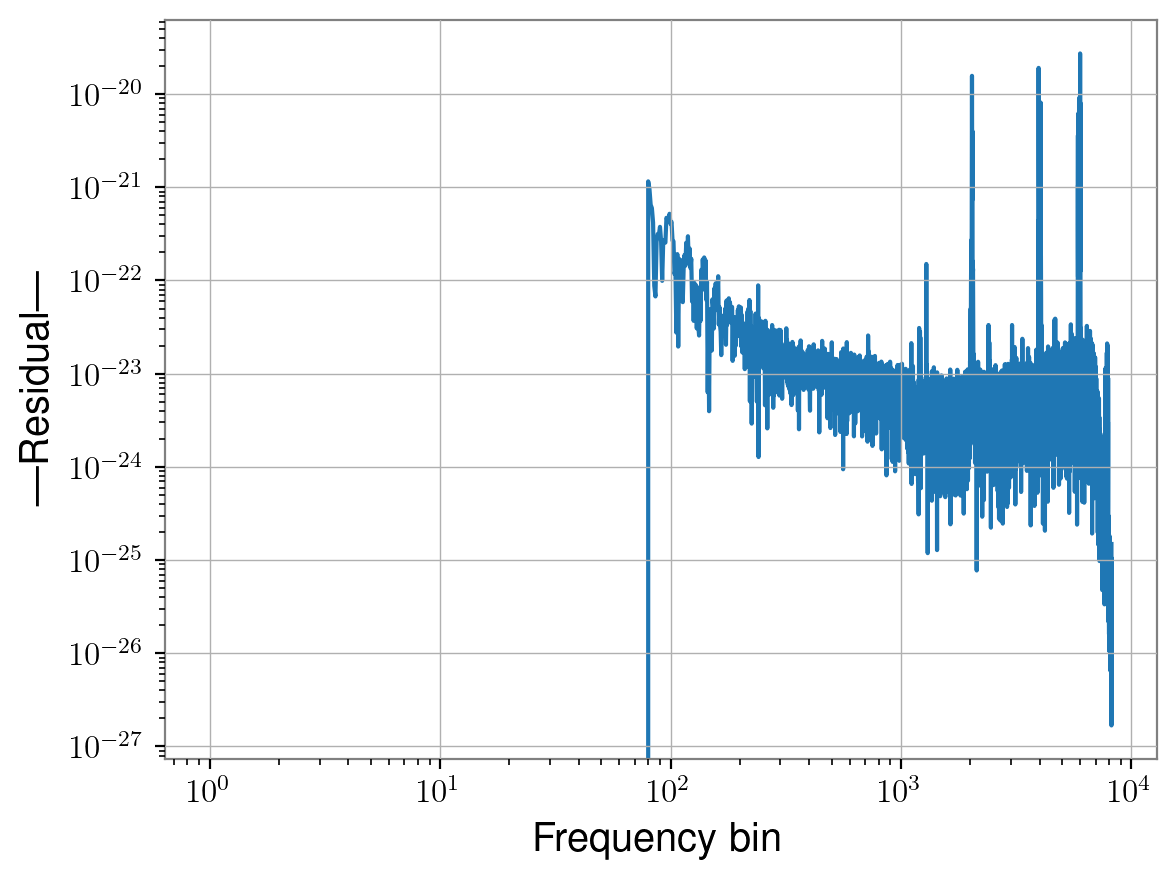

In [7]:
# Plot residual spectrum (magnitude)
plt.plot(np.abs(result['H1']['residual_fd']))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('|Residual|')
plt.xlabel('Frequency bin')

Text(0.5, 0, 'Frequency bin')

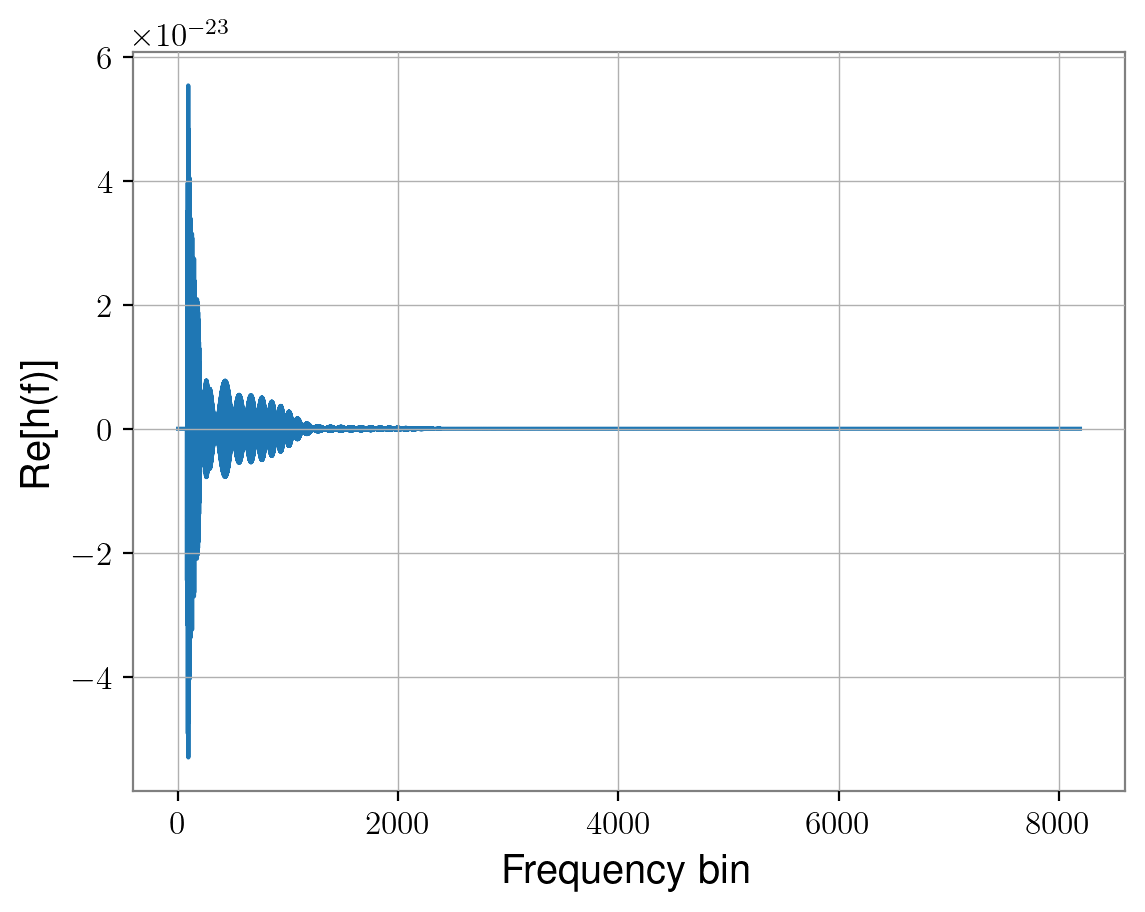

In [8]:
# Plot model waveform (real part)
plt.plot(np.real(result['H1']['model_fd']))
plt.ylabel('Re[h(f)]')
plt.xlabel('Frequency bin')

## Compute the $A_{m}$ posterior 

In [9]:
import utils

lal.MSUN_SI != Msun


In [10]:
h_memories_in_det = utils.make_memories(res, ell_max=4)

/Users/keefemitman/Desktop/Research/MemoryPop/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/keefemitman/Desktop/Research/MemoryPop/.venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:857: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/keefemitman/Desktop/Research/MemoryPop/.venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7135: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


(array([  2.,  16.,  65., 396., 483.,  30.,   5.,   1.,   0.,
          2.]),
 array([-44.19996551, -34.14790926, -24.09585301, -14.04379676,
         -3.99174051,   6.06031574,  16.11237199,  26.16442824,
         36.21648449,  46.26854074,  56.32059699]),
 <BarContainer object of 10 artists>)

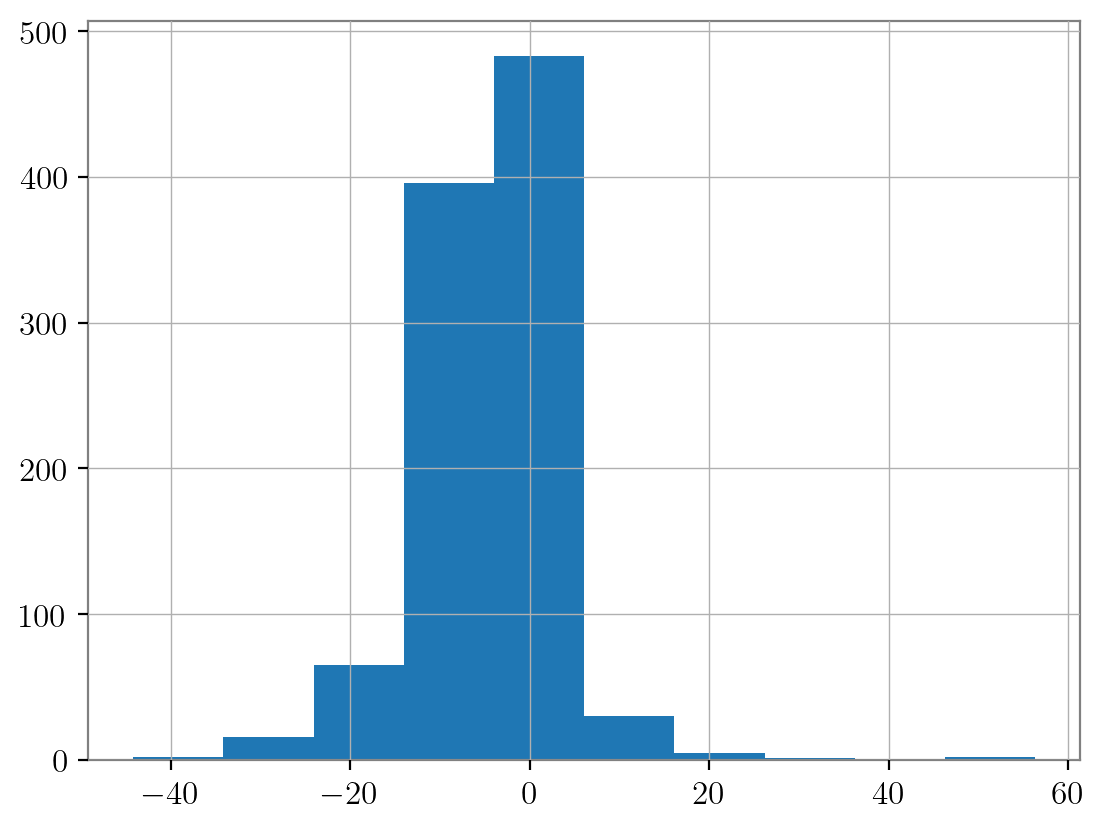

In [11]:
memory_variables_likelihoods_and_weights = utils.compute_memory_variables_likelihoods_and_weights(res, h_memories_in_det) 
plt.hist(memory_variables_likelihoods_and_weights[:,2])